In [25]:
# Import all relevant libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

from torchsummary import summary
from torchviz import make_dot

import matplotlib.pyplot as plt
import numpy as np 
import time

seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True  
torch.backends.cudnn.benchmark = False #for a small dataset, simple network , this is not really needed
np.random.seed(seed)

In [13]:
# Define the directory path
data_dir = './processed_dataset'

# Create the ImageFolder dataset
dataset = datasets.DatasetFolder(data_dir, loader=torch.load, extensions=".pt")

# Split the dataset into training and testing sets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # Remaining 20% for testing

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [14]:
# Set DataLoader
batchSize = 16  # Rule of thumb is to set to the power of 2. In this case 2^7
train_loader = DataLoader(train_dataset, batch_size=batchSize,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batchSize, shuffle=False) # no need to shuffle test data

count_batch_train, count_batch_test = 0, 0

In [15]:
for xb, yb in train_loader:
  print(count_batch_train, end='', flush=True)
  count_batch_train += 1
  print("\r", end='', flush=True)
print(f'There are {count_batch_train} batches in train_loader')

for xb, yb in test_loader:
  print(count_batch_test, end='', flush=True)
  count_batch_test += 1
  print("\r", end='', flush=True)
print(f'There are {count_batch_test} batches in test_loader')

for i, j in train_loader:
    size = i.shape
    break

print(size)

There are 413 batches in train_loader
There are 104 batches in test_loader
torch.Size([16, 1, 224, 224])


In [18]:
def printSummary(model, name="network", size=(1, 784), visualize=False):
    print("NETWORK NAME: ", name)
    summary(model, size)
    print(2*"\n")
    if visualize:
        # Generate a visualization of the network
        x = torch.randn(1, size[1])
        y = model(x)
        dot = make_dot(y, params=dict(model.named_parameters()))
        dot.render(name, format="png")

In [19]:
class MLPNetwork(nn.Module):
  def __init__(self, input_size, hidden_sizes, num_classes):
    super(MLPNetwork,self).__init__()

    self.input_layer = nn.Linear(input_size, hidden_sizes[0])
    
    self.hidden_layers = nn.ModuleList()
    for i in range(1, len(hidden_sizes)):
      self.hidden_layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))

    self.output_layer = nn.Linear(hidden_sizes[-1], num_classes)

  def forward(self, x): 
    out = self.input_layer(x)
    out = torch.sigmoid(out)

    for hidden_layer in self.hidden_layers:
      out = hidden_layer(out)
      out = torch.sigmoid(out)

    out = self.output_layer(out)

    if not self.training:
      out = F.softmax(out, dim=1)
    return out

In [20]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        # Convolutional layer 1: 3 input channels, 16 output channels, 3x3 kernel size, stride of 1, padding of 1
        self.conv1 = nn.Conv2d(1, 128, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling with 2x2 kernel and stride of 2

        # Convolutional layer 2: 16 input channels, 32 output channels, 3x3 kernel size, stride of 1, padding of 1
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling with 2x2 kernel and stride of 2

        # Convolutional layer 3: 16 input channels, 32 output channels, 3x3 kernel size, stride of 1, padding of 1
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling with 2x2 kernel and stride of 2

        # Fully connected layer 1: Input size 32*56*56 (224/2^2), output size 64
        self.fc1 = nn.Linear(32 * 28 * 28, 64)
        self.relu4 = nn.ReLU()

        # Fully connected layer 2: Input size 64, output size 2
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.conv1(x)  # Apply convolutional layer 1
        x = self.relu1(x)  # Apply ReLU activation function
        x = self.pool1(x)  # Apply max pooling

        x = self.conv2(x)  # Apply convolutional layer 2
        x = self.relu2(x)  # Apply ReLU activation function
        x = self.pool2(x)  # Apply max pooling

        x = self.conv3(x)  # Apply convolutional layer 2
        x = self.relu3(x)  # Apply ReLU activation function
        x = self.pool3(x)  # Apply max pooling

        x = x.view(x.size(0), -1)  # Flatten the tensor

        x = self.fc1(x)  # Apply fully connected layer 1
        x = self.relu4(x)  # Apply ReLU activation function
        x = self.fc2(x)  # Apply fully connected layer 2

        return x

In [27]:
class ConvNet(nn.Module):
    def __init__(self, input_channels, hidden_channels, num_classes):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, hidden_channels[0], kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()

        self.conv_layers = nn.ModuleList()
        self.pool_layers = nn.ModuleList()  # Add module list for pooling layers

        for i in range(1, len(hidden_channels)):
            self.conv_layers.append(nn.Conv2d(hidden_channels[i-1], hidden_channels[i], kernel_size=3, stride=1, padding=1))
            self.relu = nn.ReLU()
            self.pool_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))  # Add max pooling layer

        self.fc = nn.Linear(hidden_channels[-1], num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)

        for conv_layer, pool_layer in zip(self.conv_layers, self.pool_layers):  # Iterate over conv and pool layers
            out = conv_layer(out)
            out = self.relu(out)
            out = pool_layer(out)  # Apply max pooling

        out = F.avg_pool2d(out, kernel_size=out.size()[2:])  # Global average pooling
        out = out.view(out.size(0), -1)  # Flatten the tensor

        out = self.fc(out)

        if not self.training:
            out = F.softmax(out, dim=1)
        
        return out

In [22]:
def trainModel(model, data_loader, epochSize=20):
    train_loader, test_loader = data_loader[0], data_loader[1]
    
    loss_fn = nn.CrossEntropyLoss() 
    opt = torch.optim.Adam(model.parameters())

    loss_per_epoch = []
    train_acc_per_epoch = []
    test_acc_per_epoch = []
    time_per_epoch = []
    exec_time = []

    start_total_time = time.time()
    for epoch in range(epochSize):
        
        loss = 0
        start_epoch_time = time.time()

        count = 1
        for input_batch, target_batch in train_loader:
            print(f"Epoch: {epoch} => {time.time() - start_epoch_time:.2f}s {(count/count_batch_train)*100:.3f}%", end='', flush=True)

            # Zero the gradients
            opt.zero_grad() 

            # Forward pass
            predict_batch = model(input_batch) 

            # Compute loss
            loss_batch = loss_fn(predict_batch,target_batch)  

            # Backward pass and update weights
            loss_batch.backward() 
            opt.step()

            loss += loss_batch.item() #store the loss
            count+=1
            print('\r', end='', flush=True)
            
        loss_per_epoch.append(loss)
        # print(loss)
        
        time_epoch = time.time() - start_epoch_time 
        time_current = time.time() - start_total_time

        time_per_epoch.append(time_epoch)
        exec_time.append(time_current)

        # CALCULATE TRAIN ACCURACY
        correct = 0
        total = 0
        train_accuracy = 0

        with torch.no_grad():
            count = 1
            for images, labels in train_loader:
                print(f"Epoch: {epoch} => {time.time() - start_epoch_time:.2f}s || Calculating Training Accuracy... {(count/count_batch_train)*100:.3f}%", end='', flush=True)
                # Forward pass
                outputs = model(images)

                # Get the predicted labels
                _, predicted = torch.max(outputs.data, 1)

                # Update counts
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                count += 1
                print('\r', end='', flush=True)

        # Calculate accuracy
        train_accuracy = correct / total
        train_acc_per_epoch.append(train_accuracy)

        # CALCULATE TEST ACCURACY
        correct = 0
        total = 0
        test_accuracy = 0

        with torch.no_grad():
            count = 1
            for images, labels in test_loader:
                print(f"Epoch: {epoch} => {time.time() - start_epoch_time:.2f}s || Calculating Testing Accuracy... {(count/count_batch_test)*100:.3f}%", end='', flush=True)
                # Forward pass
                outputs = model(images)

                # Get the predicted labels
                _, predicted = torch.max(outputs.data, 1)

                # Update counts
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                count += 1
                print('\r', end='', flush=True)

        # Calculate accuracy
        test_accuracy = correct / total
        test_acc_per_epoch.append(test_accuracy)

        print(f'Epoch: {epoch+1} || Loss: {loss} || Train Accuracy: {train_accuracy * 100:.4f}% || Test Accuracy: {test_accuracy * 100:.4f}% || Epoch Time: {time_epoch:.4f} s || Current Runtime: {time_current:.4f} s')
    
    output = {
        'loss': loss_per_epoch,
        'train_acc': train_acc_per_epoch,
        'test_acc': test_acc_per_epoch,
        'epoch_time': time_per_epoch,
        'exec_time': exec_time
    }

    return output

In [ ]:
model_MLP = MLPNetwork(50176, [25088, 12544, 6272, 2048, 256, 64], 5)
printSummary(model_MLP, size=(1, 50176), name="model_MLP_v1")
model_MLP_result = trainModel(model_MLP, [train_loader, test_loader], epochSize=10)

In [ ]:
model_CNN = CNN(num_classes=5)

epochSize = 5
result = trainModel(model_CNN, [train_loader, test_loader], epochSize)

In [29]:
model_CNN2 = ConvNet(1, [8], 5)
# printSummary(model_CNN2, size=(1, 50176), name="model_ConvNet_v1")
model_CNN2_result = trainModel(model_CNN2, [train_loader, test_loader], epochSize=10)

Epoch: 1 || Loss: 650.1230316162109 || Train Accuracy: 37.0152% || Test Accuracy: 35.1515% || Epoch Time: 34.4303 s || Current Runtime: 34.4303 s
Epoch: 2 || Loss: 581.5111222267151 || Train Accuracy: 38.0303% || Test Accuracy: 37.1515% || Epoch Time: 33.9613 s || Current Runtime: 83.8098 s
Epoch: 3 || Loss: 517.8791490793228 || Train Accuracy: 42.4091% || Test Accuracy: 42.3636% || Epoch Time: 32.1931 s || Current Runtime: 131.8214 s
Epoch: 4 || Loss: 481.87646263837814 || Train Accuracy: 43.3788% || Test Accuracy: 44.3030% || Epoch Time: 32.6907 s || Current Runtime: 179.4607 s
Epoch: 5 || Loss: 461.24024748802185 || Train Accuracy: 44.8182% || Test Accuracy: 46.9091% || Epoch Time: 33.3239 s || Current Runtime: 228.0757 s
Epoch: 6 || Loss: 448.2452073097229 || Train Accuracy: 46.3788% || Test Accuracy: 47.8182% || Epoch Time: 34.6565 s || Current Runtime: 278.4609 s
Epoch: 7 || Loss: 439.35187989473343 || Train Accuracy: 46.9848% || Test Accuracy: 48.5455% || Epoch Time: 32.7075 s |

Text(0, 0.5, 'CE Loss')

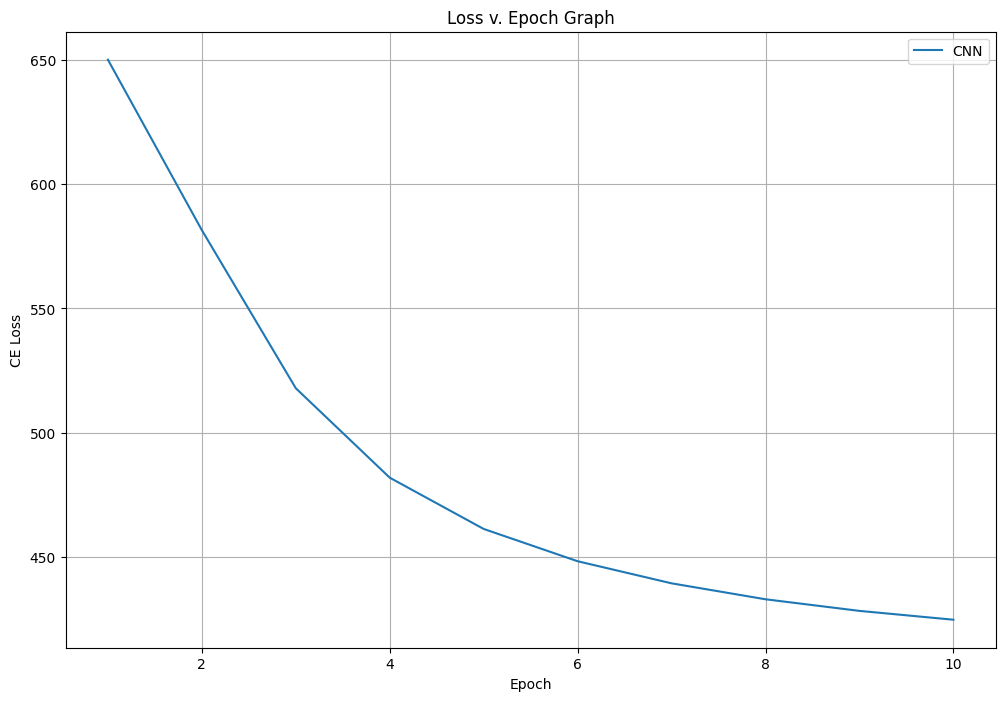

In [32]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))

# Loss v. Epoch Graph
ax1.plot(range(1, 10+1), model_CNN2_result['loss'], label="CNN")
ax1.legend()
ax1.grid()
ax1.set_title("Loss v. Epoch Graph")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("CE Loss")

[]

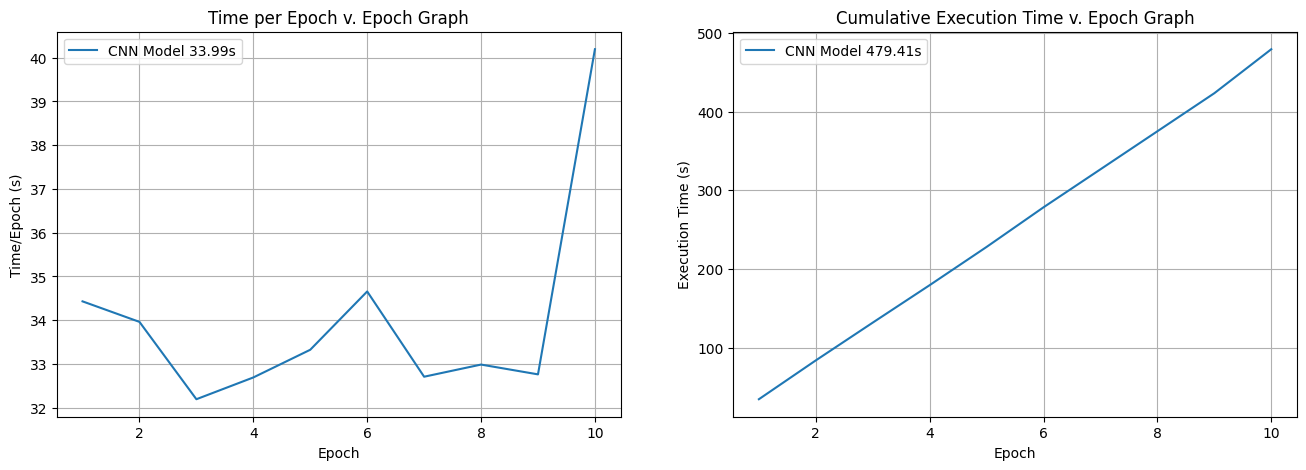

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

epochSize = 10
# Time per Epoch v. Epoch Graph
ax1.plot(range(1, epochSize+1), model_CNN2_result['epoch_time'], label=f"CNN Model {np.mean(model_CNN2_result['epoch_time']):.2f}s")
ax1.set_title("Time per Epoch v. Epoch Graph")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Time/Epoch (s)")
ax1.legend()
ax1.grid()

# Time per Epoch v. Epoch Graph
ax2.plot(range(1, epochSize+1), model_CNN2_result['exec_time'], label=f"CNN Model {model_CNN2_result['exec_time'][-1]:.2f}s")
ax2.set_title("Cumulative Execution Time v. Epoch Graph")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Execution Time (s)")
ax2.legend()
ax2.grid()
plt.plot()

In [39]:
def evaluate_model(model, data_loader, model_name=""): #or def compute_accuracy():  , use whatever conventions that you like

    model.eval()

    train_loader, test_loader = data_loader[0], data_loader[1]

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in train_loader:
            # Forward pass
            outputs = model(images)

            # Get the predicted labels
            _, predicted = torch.max(outputs.data, 1)

            # Update counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = correct / total
    print(f"{model_name} => Train Accuracy: {accuracy * 100:.2f}% || Correct Labels: {correct} / Wrong Labels: {total-correct}")

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            # Forward pass
            outputs = model(images)

            # Get the predicted labels
            _, predicted = torch.max(outputs.data, 1)

            # Update counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = correct / total
    print(f"{model_name} => Test Accuracy: {accuracy * 100:.2f}% || Correct Labels: {correct} / Wrong Labels: {total-correct}")

evaluate_model(model_CNN2, [train_loader, test_loader], "CNN")

CNN => Train Accuracy: 48.36% || Correct Labels: 3192 / Wrong Labels: 3408
CNN => Test Accuracy: 51.33% || Correct Labels: 847 / Wrong Labels: 803


Text(0.5, 1.0, 'CNN Accuracy v. Epoch')

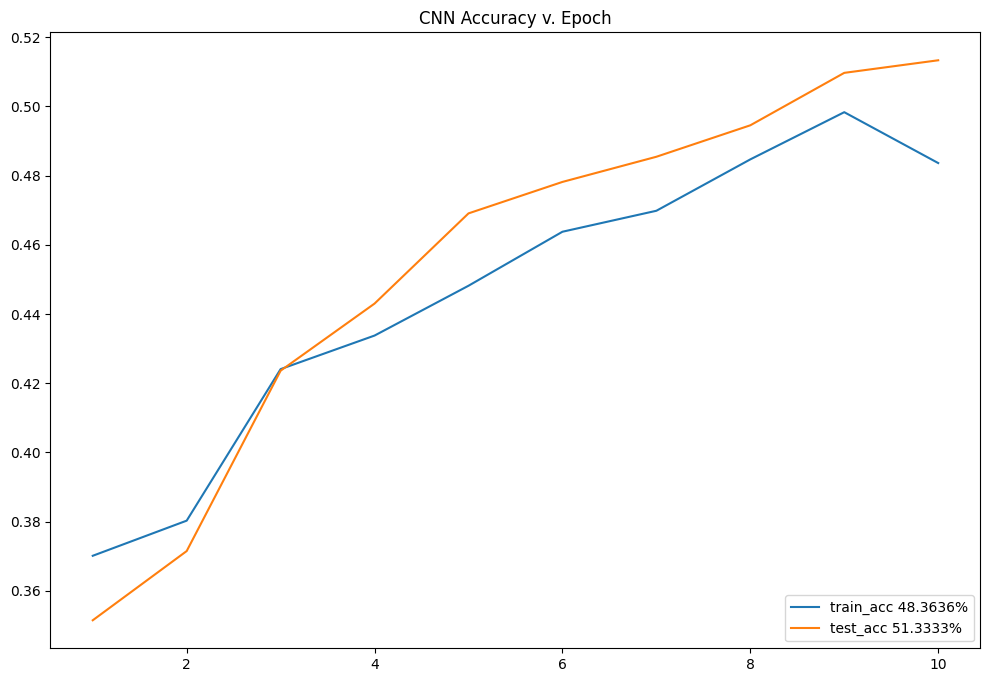

In [41]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))

# Accuracy v. Epoch Graph
ax1.plot(range(1, epochSize+1), model_CNN2_result['train_acc'], label=f"train_acc {model_CNN2_result['train_acc'][-1]*100:.4f}%")
ax1.plot(range(1, epochSize+1), model_CNN2_result['test_acc'], label=f"test_acc {model_CNN2_result['test_acc'][-1]*100:.4f}%")
ax1.legend(loc='lower right')
ax1.set_title("CNN Accuracy v. Epoch")

In [43]:
# Save the model
scripted_model = torch.jit.script(model_CNN2)
torch.jit.save(scripted_model, './models/model_ConvNet_v1.pt')
print("Saved!")

Saved!
